# Using an example KNMI radar data file (h5) as inspiration

Given are lat/ lon coordinates of the corners, number of columns, number of rows, single pixel size and projection format description.

##### Corners:

In [1]:
lat_sw = 49.362
lon_sw = 0

lat_nw = 55.974
lon_nw = 0

lon_se = 9.009
lat_se = 48.895

lon_ne = 10.856
lat_ne = 55.389

##### Define projection from Metadata

In [2]:
projparams = {
    'proj': 'stere',
    'lat_0': 90,
    'lon_0': 0,
    'lat_ts': 60,
    'a': 6378.137,
    'b': 6356.752,
    'x_0': 0,
    'y_0':0    
}

#### Import packages

In [3]:
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
% matplotlib inline

##### Define the custom projection (RAD)

In [4]:
p1 = pyproj.Proj(projparams)

##### Transform corner (lat/lon) to projection coordinates (x/y)

In [5]:
x_nw, y_nw = p1(0, lat_nw)
print(x_nw, y_nw)
x_sw , y_sw = p1(0, lat_sw)
print(x_sw, y_sw)
x_ne, y_ne = p1(lon_ne, lat_ne)
print(x_ne, y_ne)
x_se, y_se = p1(lon_se, lat_se)
print(x_se, y_se)

0.0 -3649.950249305968
0.0 -4415.006464486906
699.9723061714168 -3649.997949483507
699.984286636589 -4415.038230564286


##### Even though there are smaller differences I think it's reasonable to use them as linear x and y coords

In [6]:
x_data = np.linspace(x_nw, x_ne, 700)
y_data = np.linspace(y_nw, y_sw, 765)

###### Let's see if the coordinates are still in range

In [7]:
p1(x_data[-1], y_data[-1], inverse=True) # SE corner

(9.008912092597194, 48.89528100378207)

Yep looks good.

Now these can be put e.g. into a meshgrid and do our check which points are inside a defined polygon. Beware that one has to transform the new coordinates first to this projection (p1) or transfrom the existing p1 coordinates into another format.

In [8]:
xgrid, ygrid = np.meshgrid(x_data, y_data)
XY = np.dstack((xgrid, ygrid))
XY_flat = XY.reshape((-1, 2))
len(XY_flat)

535500

##### Okay let's define and transform our custom polygon to the p1 projection

In [9]:
polygon = [[51.335015, 3.371926],
[51.253118, 4.082179],
[51.441892, 4.646351],
[51.388485, 5.109778],
[51.145800, 5.774696],
[50.854157, 5.628615],
[50.752286, 5.769658],
[50.755473, 6.061819],
[50.943112, 6.102117],
[51.523453, 6.238123],
[51.826451, 6.061819],
[51.944600, 6.852668],
[53.214769, 7.260685],
[53.497372, 6.872817],
[54.603298, 4.021732],
[51.454449, 3.145250]]

In [10]:
wgs84 = pyproj.Proj(init='epsg:4326')
new_points = []
for cur_point in polygon:
    cur_lat = cur_point[0]
    cur_lon = cur_point[1]
    new_x, new_y = pyproj.transform(wgs84, p1, cur_lon, cur_lat, radians=False)
    new_points.append([new_x, new_y])
print(np.array(new_points))

[[  246.07027518 -4176.39876599]
 [  298.50149047 -4182.55215453]
 [  337.88815179 -4157.47940782]
 [  372.05798886 -4160.80827487]
 [  423.16556161 -4184.36720443]
 [  415.83673565 -4219.33208718]
 [  427.41961024 -4230.1478772 ]
 [  448.94484172 -4227.5426985 ]
 [  449.58628387 -4205.41417172]
 [  452.2124318  -4137.04648453]
 [  435.75796389 -4103.36688917]
 [  490.71515981 -4083.33189392]
 [  501.20361761 -3933.92205716]
 [  470.66499273 -3904.89838486]
 [  266.94923561 -3796.85587862]
 [  228.78195236 -4163.44348181]]


###### Let's define our path and see which points are inside

In [11]:
path = mpltPath.Path(new_points)
inside_flat = path.contains_points(XY_flat)
print(inside_flat.any())
len(inside_flat)

True


535500

In [12]:
XY_flat[inside_flat]

array([[  267.37139592, -3797.15347395],
       [  267.37139592, -3798.15485644],
       [  268.37278692, -3798.15485644],
       ..., 
       [  428.59534627, -4229.75070558],
       [  429.59673726, -4229.75070558],
       [  430.59812826, -4229.75070558]])

In [13]:
len(XY_flat[inside_flat])

76572

#### Okay let's transform it back to our grid shape!

In [14]:
inside = inside_flat.reshape(xgrid.shape)

In [15]:
inside.shape

(765, 700)

##### Let's test it!

In [16]:
test_data = np.ones((765, 700))

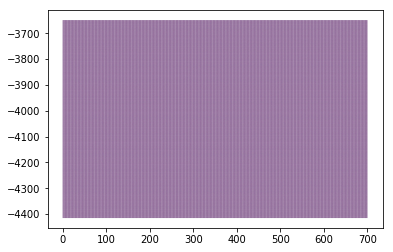

In [17]:
fig, ax = plt.subplots()
ax.scatter(xgrid, ygrid, c=test_data, s=0.1, edgecolor='')
plt.show()

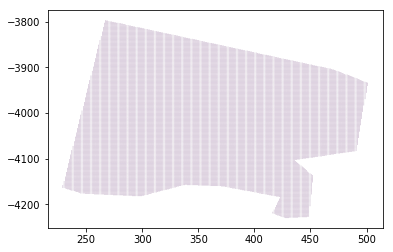

In [18]:
fig, ax = plt.subplots()
ax.scatter(xgrid[inside], ygrid[inside], c=test_data[inside], s=0.1, edgecolor='')
plt.show()

##### Cool. Seems to work. Now it's your turn!